### Łukasz Ozimek 236529
### Laboratorium 9 (i poprawa 8)

#### Komentarz do laboratorium 8 (poprawa):
W laboratorium wykorzystano zestaw zdjęć belgijskich znaków drogowych. Zdjęcia należą do 62 klas, a różnice pomiędzy poszczególnymi obrazami są duże. Obrazy mają różnią się rozmiarami, rozdzielczością, przybliżeniem, oświetleniem oraz kątem rejestracji obrazu. Ponadto różnice między klasami w wielu przypadkach są nieznaczne np. 6 różnych znaków parkingowych różniących się jedynie symbolem w prawym dolnym rogu. Klasy różnią się również ilością obiektów które do niej należą. Obrazy poddano operacji zmniejszenia rozmiaru na 28 x 28, przekonwertowano z RGB na skalę szarości, a następnie stworzono dodatkowe tensory obrazów obróconych o -90 stopni oraz obrazów rozmytych. 

#### Laboratorium 9

* [Początek laboratorium 9](#task1)
* [Wizualizacja przykładowych znaków oraz raport dla zestawu testowego](#task2)
* [Poprawa sieci i wczesne zatrzymywanie](#task3)

Trenując model po raz pierwszy można zaobserwować, że jego dokładność stale rośnie aż do końca treningu, co oznacza, że trenowano model ze zbyt małą ilością epok. Do oszacowania dokładności modelu na zbiorze evaluate użyto metody *evaluate*, która zwraca stratę i dokładność moelu dla podanych danych. 
Następnie wykonano modyfikacje:
* Dodanie kolejnej wartswy konwolucyjnej
* Zwiększenie ilości epok do 100
* Dodanie wczesnego zatrzymywania

Warstwę konwolucyjną dodano, aby przetestować czy poprawi dokładność modelu. Można zauważyć, że już pierwsza wartość dokładności treningu jest wyższa niż w przypadku modelu z 1 wartswą konwolucyjną, co oznacza, że nowa wartstwa poprawiła dokłaność modelu. Ilość epok znacznie zwiększono aby zapewnić, że podczas treningu algorytm zdąży znaleźć optymalne rozwiązanie oraz wiedząc, że wczesne zatrzymywanie zapobiegnie znacznemu przetrenowaniu. Ostatecznie zmodyfikowany model osiągnął wyższą dokładność więc cel laboratorium został spełniony. Poniżej zaprezentowano kod.


<br><br>
Kod skopiowany z laboratorium 8 (nie zawiera rysowania wykresów oraz jest opatrzony dodatkowymi komentarzami w ramach poprawy):

In [42]:
# Code from lab 8
import numpy as np
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory)
                  if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory,f)
                     for f in os.listdir(label_directory)
                     if f.endswith('.ppm')]
        for f in file_names:
            # Sckikt Image didn't work so I used opencv
            img = cv2.imread(f)
            im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV uses BGR, but pyplot used later uses RGB
            img = np.asarray(im_rgb)
            img = img/255 # Normalizing pixels from 0-255 to 0-1
            images.append(img) 
            labels.append(int(d))

    return images, labels

root_path = '../Lab8/Data/'
train_data_directory = os.path.join(root_path, 'Training/')
test_data_directory = os.path.join(root_path, 'Testing/')

images, labels = load_data(train_data_directory) # Loading images

images28 = [cv2.resize(image, (28, 28)) for image in images] # Resize images to 28 x 28

# Function to convert images to grayscale
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

images_gray = [rgb2gray(image) for image in images28] # Convert images to grayscale

images_rotated = [np.transpose(image) for image in images_gray] # Create rotated gray images

import scipy.ndimage as scp
images_blurred = [scp.gaussian_filter(image, 2) for image in images_gray] # Create blurred gray images


<a id='task1'></a>

In [43]:
print("Length of images array: %d; length of labels array: %d" % 
      (len(images_gray),len(labels))) # Printing array sizes before joining

images_gray = images_gray + images_rotated # Appending rotated images
images_gray= images_gray + images_blurred # Appending blurred images
labels = labels + labels # Appending labels for rotated images
labels = labels + labels[0:int((len(labels))/2)] # Appending labels for blurred images

print("Length of images array: %d; length of labels array: %d" % 
      (len(images_gray),len(labels))) # Printing array sizes after joining, sizes of images and labels must be the same

Length of images array: 4575; length of labels array: 4575
Length of images array: 13725; length of labels array: 13725


In [44]:
images_data = np.asarray(images_gray) # Converting image array to numpy array
images_data = np.expand_dims(images_data, -1) # Converting (x, 28, 28) array to (x, 28, 28, 1) array
targets = np.asarray(labels) # Converting labels array to numpy array
X_train, X_test, y_train, y_test = train_test_split(images_data, targets, test_size = 0.3)

In [45]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(8, (2, 2), activation='relu', input_shape=[28, 28, 1]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(62, activation='relu'))
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])

In [46]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10)

Epoch 1/10
301/301 [==============================] - 2s 6ms/step - loss: 3.4322 - accuracy: 0.2668 - val_loss: 3.2052 - val_accuracy: 0.3142
Epoch 2/10
301/301 [==============================] - 2s 6ms/step - loss: 3.1195 - accuracy: 0.3253 - val_loss: 3.1117 - val_accuracy: 0.3208
Epoch 3/10
301/301 [==============================] - 3s 8ms/step - loss: 3.0413 - accuracy: 0.3315 - val_loss: 3.0253 - val_accuracy: 0.3422
Epoch 4/10
301/301 [==============================] - 2s 7ms/step - loss: 2.9950 - accuracy: 0.3373 - val_loss: 3.0142 - val_accuracy: 0.3344
Epoch 5/10
301/301 [==============================] - 2s 7ms/step - loss: 2.9617 - accuracy: 0.3417 - val_loss: 2.9753 - val_accuracy: 0.3385
Epoch 6/10
301/301 [==============================] - 3s 9ms/step - loss: 2.9379 - accuracy: 0.3433 - val_loss: 2.9622 - val_accuracy: 0.3390
Epoch 7/10
301/301 [==============================] - 3s 8ms/step - loss: 2.9173 - accuracy: 0.3461 - val_loss: 2.9458 - val_accuracy: 0.3434
Epoch 

In [47]:
sample_indexes = random.sample(range(len(images_data)),10)
sample_images = images_data[sample_indexes]
sample_labels = targets[sample_indexes]
y_pred = model.predict(sample_images)
sample_images = [np.squeeze(images_data[i],axis=2) for i in sample_indexes] # Converting array from (28x28x1) to (28x28) for plt
y_pred = np.argmax(y_pred, axis=1) # Converting 10 x 62 array into 10 x 1 array by returning index of max value

In [48]:
print('Predicted values:')
print(y_pred)
print('Actual values:')
print(sample_labels)

Predicted values:
[32 22 41  1 32  0  0  1 61 22]
Actual values:
[32 22 37 19 53  7 47 34 61 40]


<a id='task2'></a>

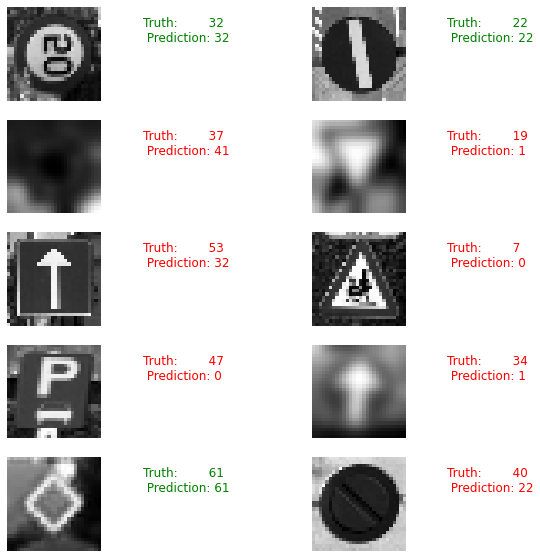

In [49]:
fig = plt.figure(figsize=(10,10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = y_pred[i]
    plt.subplot(5, 2, 1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\n Prediction: {1}".format(truth, prediction),
            fontsize=12, color = color)
    plt.imshow(sample_images[i], cmap='gray')

In [50]:
test_images, test_labels = load_data(test_data_directory)
test_images = [cv2.resize(image, (28, 28)) for image in test_images] # Resize images to 28 x 28

test_images = [rgb2gray(image) for image in test_images] # Convert images to grayscale
images_data_test = np.asarray(test_images) # Converting image array to numpy array
images_data_test = np.expand_dims(images_data_test, -1) # Converting (x, 28, 28) array to (x, 28, 28, 1) array
targets_test = np.asarray(test_labels) # Converting labels array to numpy array
y_eval = model.evaluate(images_data_test, targets_test) # Acquiring loss and accuracy for the testing set
print('Loss: %f;\t \t Accuracy: %f' % (y_eval[0], y_eval[1]))

79/79 [==============================] - 0s 2ms/step - loss: 2.6966 - accuracy: 0.3869
Loss: 2.696649;	 	 Accuracy: 0.386905


<a id='task3'></a>

In [54]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(4, (2, 2), activation='relu', input_shape=[28, 28, 1]))
model.add(tf.keras.layers.Conv2D(4, (2, 2), activation='relu')) # Additional convolution layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(62, activation='relu'))
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)] # Adding early stopping callback
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, callbacks=my_callbacks) # Training with 100 epochs
print('\n Training report:')
print('Train loss: %f;\t Train accuracy: %f \t Validation loss: %f;\t Validation accuracy: %f' 
      % (model.history.history['loss'][-1],model.history.history['accuracy'][-1],
         model.history.history['val_loss'][-1],model.history.history['val_accuracy'][-1]))
          
y_eval = model.evaluate(images_data_test, targets_test) # Acquiring loss and accuracy for the testing set
print('\n Testing report:')
print('Loss: %f;\t \t Accuracy: %f' % (y_eval[0], y_eval[1]))

Epoch 1/100
301/301 [==============================] - 2s 7ms/step - loss: 3.3141 - accuracy: 0.3032 - val_loss: 2.8940 - val_accuracy: 0.4036
Epoch 2/100
301/301 [==============================] - 2s 6ms/step - loss: 2.7774 - accuracy: 0.4172 - val_loss: 2.7314 - val_accuracy: 0.4172
Epoch 3/100
301/301 [==============================] - 2s 7ms/step - loss: 2.6486 - accuracy: 0.4327 - val_loss: 2.6128 - val_accuracy: 0.4378
Epoch 4/100
301/301 [==============================] - 2s 6ms/step - loss: 2.5681 - accuracy: 0.4408 - val_loss: 2.5781 - val_accuracy: 0.4407
Epoch 5/100
301/301 [==============================] - 2s 6ms/step - loss: 2.5132 - accuracy: 0.4478 - val_loss: 2.5388 - val_accuracy: 0.4485
Epoch 6/100
301/301 [==============================] - 2s 7ms/step - loss: 2.4723 - accuracy: 0.4528 - val_loss: 2.5633 - val_accuracy: 0.4276
Epoch 7/100
301/301 [==============================] - 2s 7ms/step - loss: 2.4439 - accuracy: 0.4547 - val_loss: 2.5094 - val_accuracy: 0.4468